In [1]:
import os
import numpy as np
import h5py
import scipy.signal as ss
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append('/Users/zhengj10/Python/Modules')
import PatcherBot as pb
import yaml



In [4]:
dataPath = '/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/'
date= '2021.06.28_000'
plate = 'plate_000'


In [7]:
cell = 'patch_attempt_0005_000'

dataFile = os.path.join(dataPath,date,plate,cell,'sIPSC&imaging_000/000','Clamp1.ma')

data = h5py.File(dataFile,'r')
iv_data = data['data'][()]
trace = iv_data[1,:]
trace = trace*1e12
# trace = trace-trace[300000]

b, a = ss.butter(2, 0.05)
y = ss.filtfilt(b, a, trace, padlen=500)
y = ss.medfilt(y, kernel_size = 15)
# y = trace

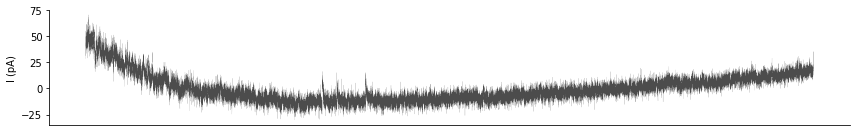

In [28]:
fig = plt.figure(figsize=[15,2])
x = np.arange(y.shape[0])/40000.0
ax = plt.subplot(111)
ax.plot(x,y,color='k',lw=0.1,alpha=0.7)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.set_xlabel('S')
ax.set_ylabel('I (pA)')
ax.axes.get_xaxis().set_visible(False)
plt.tight_layout()
# fig.savefig('/Users/zhengj10/Desktop/210526/iGABASnFR/mIPSCs'+cell+'.png',dpi=1200)
plt.show()


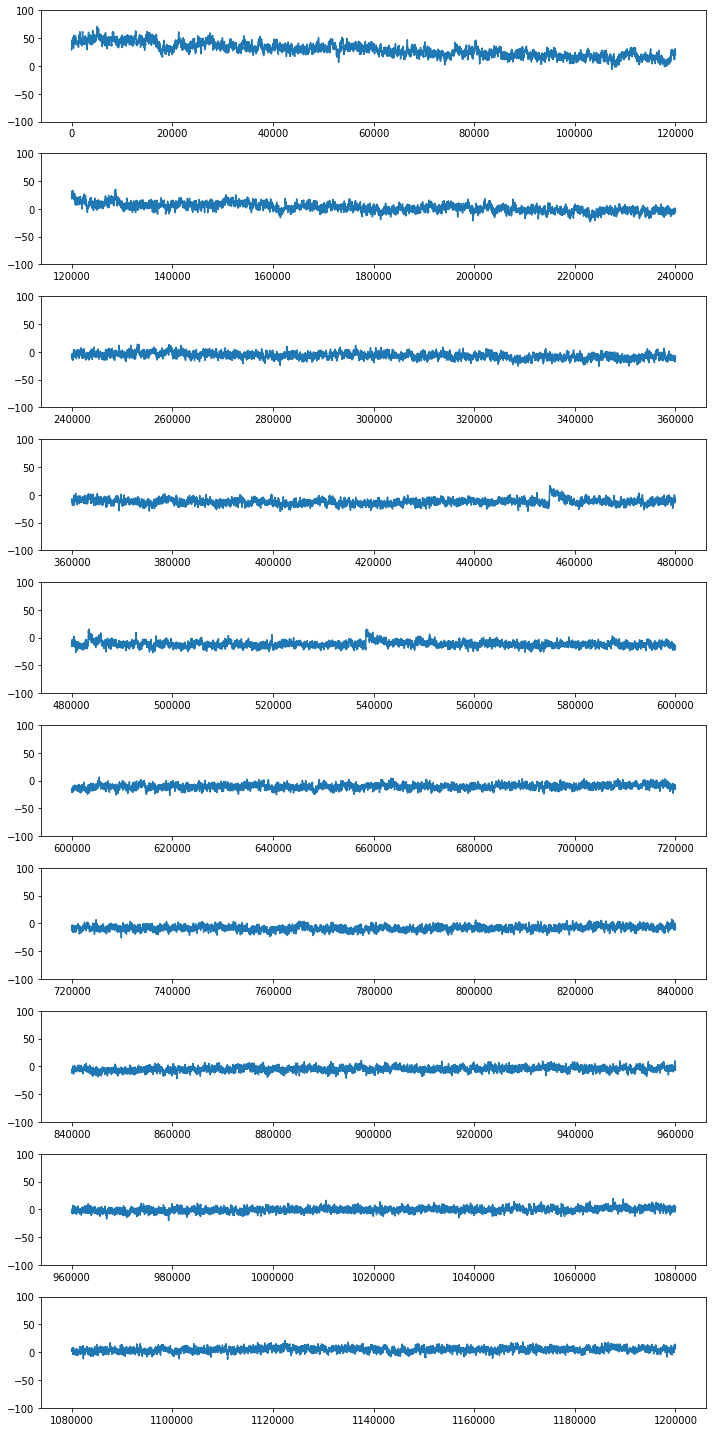

In [11]:
y = ss.detrend(y)
x = np.arange(y.shape[0])
fig = plt.figure(figsize=[10,20])
for i in range(10):
    ax = plt.subplot(10,1,i+1)
    ax.plot(x[i*120000:(i+1)*120000],y[i*120000:(i+1)*120000])
    ax.set_ylim([-100,100])
plt.tight_layout()
plt.show()


In [12]:
## Cells showing putative mIPSCs

# ['patch_attempt_0000_000','patch_attempt_0004_000','patch_attempt_0007_000','patch_attempt_0011_000']

In [13]:
dataFile = os.path.join(dataPath,date,plate,cell,'sIPSC&imaging_000/000/camera','frames.ma')

data = h5py.File(dataFile,'r')
imgData = data['data'][()]
print(imgData.shape)

(3000, 508, 508)


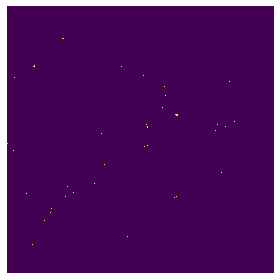

In [14]:
img_norm = (imgData/imgData[0])-1

act_pix = []
for i in range(10,1047):
    a = (np.mean(img_norm[i+1:i+10,:,:],axis=0)-np.mean(img_norm[i-10:i,:,:],axis=0))>0.04
    act_pix.append(a)
act_pix = np.array(act_pix)
act_pix = np.max(act_pix,axis=0)
plt.axis('off')
plt.tight_layout()
plt.imshow(act_pix)


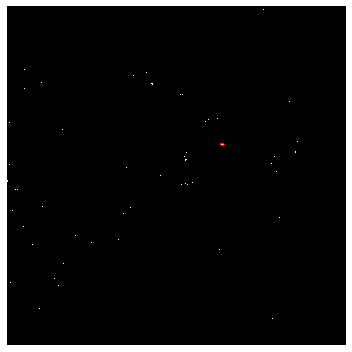

In [15]:
from skimage import measure
contours = measure.find_contours(act_pix, 0.1)



fig = plt.figure(figsize=[5,5])
plt.imshow(act_pix,cmap='gray')
thre = 20 # Exclude small ROIs
# roi = 0
for contour in contours:
    if contour.shape[0]>thre:
#         roi+=1
        plt.plot(contour[:,1], contour[:, 0], color = 'r',lw=1)
plt.axis('off')
plt.tight_layout()
# fig.savefig('/Users/zhengj10/Desktop/210526/iGABASnFR/ROIs'+cell+'.png',dpi=1200)
plt.show()


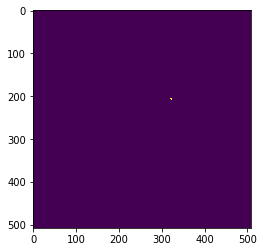

In [16]:
from matplotlib.path import Path
mean_image = imgData[0,:,:]
# plt.figure(figsize=[12,12])
plt.imshow(np.zeros([508,508]))
coordinates = []
for r in range(act_pix.shape[0]):
    for c in range(act_pix.shape[1]):
        coordinates.append([r,c])
coordinates = np.array(coordinates)

meanImg_b0 = []
rois = []
for contour in contours:
    if contour.shape[0]>thre:
        p = Path(contour)
        roi = p.contains_points(coordinates)
        roi = roi.reshape(508,508)
        f0 = np.sum(roi*mean_image)/np.sum(roi)
        rois.append(roi)
        meanImg_b0.append(roi*mean_image)


# x = np.arange(0, 20)
# y = np.arange(22, 32)
# xv, yv = np.meshgrid(x, y)
# mask = np.zeros(mean_image.shape)
# mask[yv.flatten().astype(np.int), xv.flatten().astype(np.int)] = 1
# rois.append(mask) # Add mask (fb)
meanImg_b0.append(rois[-1]*mean_image) # Add mask (fb)
rois_all = np.sum(rois,axis=0)      
        
plt.imshow(rois_all)
meanImg_b0 = np.sum(meanImg_b0,axis=0)
# plt.colorbar()
plt.show()


(3000,)


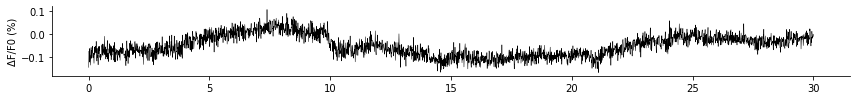

In [27]:
Fb = np.min(imgData[-1,:,:])
F0 = np.mean(imgData[:10,:,:],axis=0)
fig = plt.figure(figsize=[12,1.5])
i = 1

dataFile = os.path.join(dataPath,date,plate,cell,'sIPSC&imaging_000/000/camera','frames.ma')

data = h5py.File(dataFile,'r')
timeData = data['info']['0']['values'][()]
print(timeData.shape)

x = np.linspace(0,30,3000)

ax = plt.subplot(111)
for roi in range(len(rois)):
# for roi in range(1,2):
# for roi in [1,4]:
    offset = 0.05*i
    dFF_all = []
    for frame in range(imgData.shape[0]):
        F_single = np.sum(rois[roi]*imgData[frame,:,:])/np.sum(rois[roi])
        dFF = (F_single - np.sum(rois[roi]*F0)/np.sum(rois[roi]))/(np.sum(rois[roi]*F0)/np.sum(rois[roi])-Fb)
        dFF_all.append(dFF)
    dFF_all = np.array(dFF_all)
    dFF_all = ss.detrend(dFF_all)
#     b, a = signal.butter(8, 0.4)
#     dFF_all = ss.filtfilt(b, a, dFF_all, padlen=125)
    ax.fill_between(x,dFF_all - offset, 0 - offset, 
                 zorder=i+1, 
                 facecolor='w', edgecolor='w', 
                 lw=0, 
                 closed=True)
    ax.plot(x,dFF_all - offset, zorder=i+1, color='k', lw=0.5)

    i+=1
# plt.plot([2350,2450,2450],[-1.1,-1.1,-0.9],color='k',alpha=0.8)
ax.set_ylabel('\u0394F/F0 (%)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
# fig.savefig('/Users/zhengj10/Desktop/210526/iGABASnFR/minis_iGABASnFR'+cell+'.png',dpi=1200)


In [26]:
# len(rois)
timeData

array([0., 0., 0., ..., 0., 0., 0.])

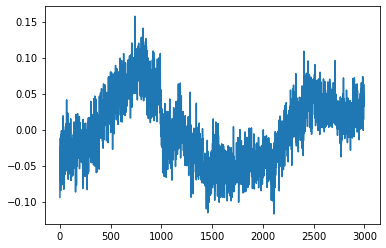

In [24]:
plt.plot(dFF_all)

In [18]:
q = []
for i in range(x.shape[0]-1):
    interval = x[i+1]-x[i]
    q.append(interval)
    

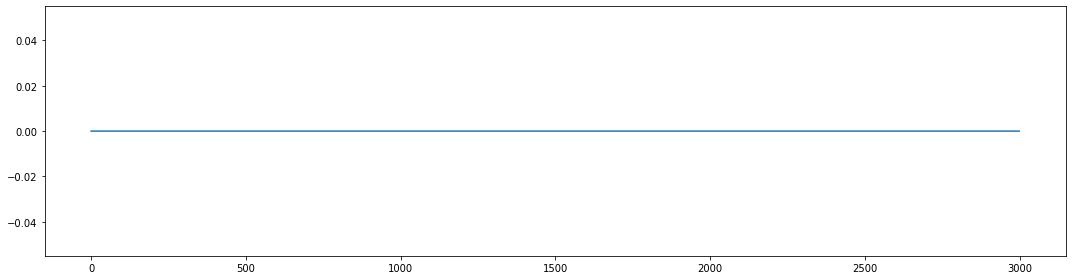

In [22]:
plt.figure(figsize=[15,4])
# plt.plot(x[:-1],q,color='k')
plt.plot(q)
plt.tight_layout()
# plt.savefig('/Users/zhengj10/Desktop/210526/iGABASnFR/frame_interval'+cell+'.png',dpi=1200)
plt.show()


In [21]:
len(q)

2999